In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

In [3]:
brain = pd.read_csv('brain.tsv', sep='\t')
carprefs = pd.read_csv('carprefs.tsv', sep='\t')

**Task 1: Brain correlations**

In [4]:
brain.head()

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,Female,133,132,124,118,64.5,816932
1,Male,140,150,124,�,72.5,1001121
2,Male,139,123,150,143,73.3,1038437
3,Male,133,129,128,172,68.8,965353
4,Female,137,132,134,147,65.0,951545


In [40]:
def z_transform(sample):
    return (sample - sample.mean()) / sample.std()


def filter_outliers(df):
    for col in df.columns:
        if col not in ['Gender', 'Weight', 'Height']:
            z_transformed = abs(z_transform(df[col]))
            df = df[z_transformed <= 3]
    return df


def check_is_normal(sample, p):
    p_value = stats.shapiro(sample)[1]
    return p_value > p, p_value


def t(r, n):
    return r * (n - 2) ** 0.5 / (1 - r ** 2) ** 0.5


def rho(x, y):
    n = len(x)
    return 1 - 6 * ((x - y) ** 2).sum() / (n ** 3 - n)


def correlation_spearman(x, y, alpha):
    corr = rho(x, y)
    n = len(x)
    p_value = stats.t.cdf(t(corr, n), df=n - 2)
    kind = 1 if p_value > 1 - alpha else -1 if p_value < alpha else 0
    return kind, p_value


def print_correlations(df):
    for iq in ['FSIQ', 'VIQ', 'PIQ']:
        corr, p_value = correlation_spearman(df[iq].rank(method='first'), df.MRI_Count.rank(method='first'), alpha=0.05)
        kind = 'positive' if corr == 1 else 'negative'
        print(str(iq).ljust(5), ' : ', 'no correlation (p_value={})'.format(p_value) if corr == 0 else '{} correlation with p_value={}'.format(kind, p_value))

In [16]:
brain = filter_outliers(brain)

**Let's take a look at the data:**

(<matplotlib.axes._subplots.AxesSubplot at 0x676e6d0>,
 (False, 3.057071444345638e-05))

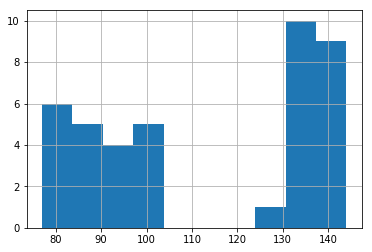

In [17]:
brain.FSIQ.hist(), check_is_normal(brain.FSIQ, p=0.05)

(<matplotlib.axes._subplots.AxesSubplot at 0x56794b0>,
 (False, 0.0084543377161026))

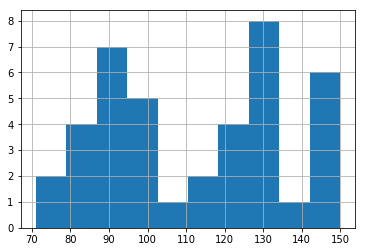

In [18]:
brain.VIQ.hist(), check_is_normal(brain.VIQ, p=0.05)

(<matplotlib.axes._subplots.AxesSubplot at 0x68b2c70>,
 (False, 0.01371809747070074))

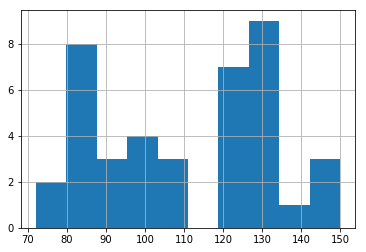

In [19]:
brain.PIQ.hist(), check_is_normal(brain.PIQ, p=0.05)

After a look at the distributions of the different IQ types, we definetely cannot assume them to be normally distributed. Hence, we cannot use the Pearson correlation coefficient, so we are going to use Spearman's one:

In [37]:
print_correlations(brain)

FSIQ   :  positive correlation with p_value=0.9988930557112823
VIQ    :  positive correlation with p_value=0.9936028267000984
PIQ    :  positive correlation with p_value=0.9953484735300792


In the general population we can assume that we have a positive correlation between all of the kinds of IQ values and the brain size.

In [38]:
print_correlations(brain[brain.Gender == 'Male'])

FSIQ   :  positive correlation with p_value=0.9976234495879531
VIQ    :  positive correlation with p_value=0.9898269358565096
PIQ    :  positive correlation with p_value=0.9988288645707587


Same situation in the male part of the general population.

In [39]:
print_correlations(brain[brain.Gender == 'Female'])

FSIQ   :  no correlation (p_value=0.9125029322921825)
VIQ    :  no correlation (p_value=0.8187130564877245)
PIQ    :  no correlation (p_value=0.9267835283526697)


But in the female population, suprisingly, we have no correlation at all.

**Task 2: Car preferences**

In [8]:
carprefs.head()

,ID,Age,Sex,LicYr,LicMth,ActCar,Kids5,Kids6,PreferCar,Car15K,...,Reliable,Perform,Fuel,Safety,AC/PS,Park,Room,Doors,Prestige,Colour
0,110,18,2,0,2,3,2,2,2,2,...,4,3,3,3,3,3,3,3,3,2
1,111,25,1,8,0,1,2,2,1,1,...,4,4,4,4,3,4,4,2,3,3
2,112,63,2,46,0,3,2,2,3,2,...,3,3,3,3,3,3,3,3,3,3
3,113,51,1,35,0,3,2,2,2,2,...,3,3,3,4,3,3,3,3,1,3
4,114,19,1,2,0,2,2,2,2,1,...,3,4,3,3,2,3,3,2,3,3


In [9]:
def chi_squared(table, alpha):
    n = table.sum(axis=0)
    m = table.sum(axis=1)
    nall, r, s = n.sum(), len(m), len(n)
    chi_value = 0
    for i in range(1, r):
        for j in range(1, s):
            chi_value += (table.iloc[i][j] - m[i] * n[j] / nall) ** 2 / (m[i] * n[j] / nall)
    p_value = stats.chi.cdf(chi_value, df=(r - 1) * (s - 1))
    corr = 1 if p_value > 1 - alpha else -1 if p_value < alpha else 0
    return corr, p_value

Since we are dealing with a categorical random values here, we will use Chi-squared test to find out if there's a correlation between the car size prefernces and gender.

In [10]:
table = pd.pivot_table(carprefs[['Sex', 'PreferCar']], index=['Sex'], columns=['PreferCar'], aggfunc=np.size)

In [11]:
table

PreferCar,1,2,3,4
Sex,,,,
1,86,150,52,12
2,50,122,94,34


In [12]:
chi_squared(table, 0.05)

(1, 1.0)

With a p_value = 1 we can definetely assume that there is a strong correlation between gender and car size preferences - males can be assumed to prefer bigger cars.